In [74]:
#Importing Dependecies 

import sqlalchemy
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sqlalchemy.orm import Session
from sqlalchemy import func



In [75]:
# Creating Engine
engine = create_engine("sqlite:///hawaii.sqlite")


In [76]:
# Creating Base
from sqlalchemy.orm import declarative_base
Base = declarative_base()



In [77]:
# Reflecting the tables
Base.metadata.reflect(engine)
Station = Base.metadata.tables['station']
Measurement = Base.metadata.tables['measurement']


In [78]:
# Creating a session

session = Session(engine)


In [79]:
#
first_row = session.query(Measurement).first()
print(f"Date: {first_row.date}, Precipitation: {first_row.prcp}, Station: {first_row.station}, TOBS: {first_row.tobs}")


Date: 2010-01-01, Precipitation: 0.08, Station: USC00519397, TOBS: 65.0


In [80]:
# Query to retrieve date and precipitation data from the Measurement table
precipitation_data = session.query(Measurement.c.date, Measurement.c.prcp).order_by(Measurement.c.date).all()

# Display the first few records to see the data
precipitation_data[:5]  # Displaying the first 5 results as a preview


[('2010-01-01', 0.08),
 ('2010-01-01', 0.28),
 ('2010-01-01', 0.21),
 ('2010-01-01', 0.15),
 ('2010-01-01', 0.15)]

In [81]:
# Find the most recent date in the dataset
most_recent_date = session.query(Measurement.c.date).order_by(Measurement.c.date.desc()).first()
most_recent_date


('2017-08-23',)

In [82]:
from datetime import datetime, timedelta

# Calculate the date one year ago from the most recent date in the dataset
year_ago_date = datetime.strptime(most_recent_date[0], "%Y-%m-%d") - timedelta(days=365)

# Query to get the precipitation data for the last 12 months
precipitation_last_year = (
    session.query(Measurement.c.date, Measurement.c.prcp)
    .filter(Measurement.c.date >= year_ago_date)
    .order_by(Measurement.c.date)
    .all()
)

# Display the first few records as a preview
precipitation_last_year[:5]


[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22)]

In [83]:
# Convert the precipitation data to a DataFrame
precipitation_df = pd.DataFrame(precipitation_last_year, columns=['date', 'precipitation'])

# Set the 'date' column as the index
precipitation_df.set_index('date', inplace=True)

# Display the first few rows to verify
precipitation_df.head()


,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


In [84]:
# Sort the DataFrame by date
precipitation_df.sort_index(inplace=True)

# Display the first few rows to verify the sorting
precipitation_df.head()


,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


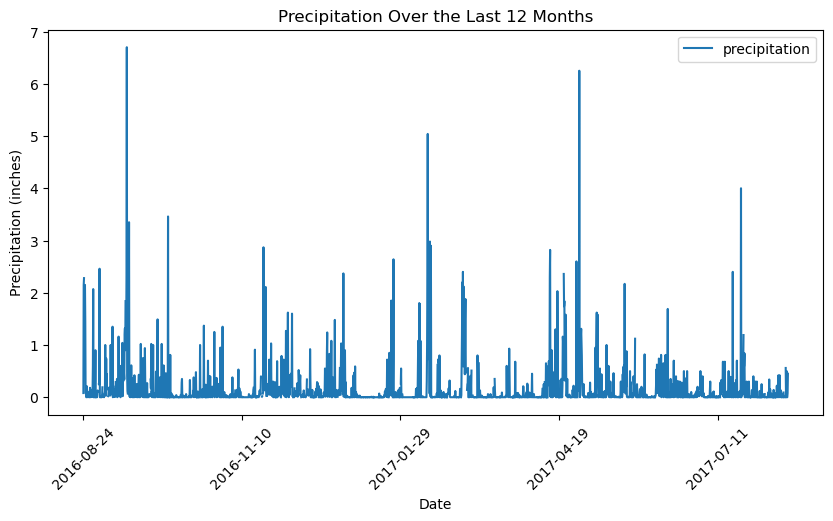

In [85]:
# Plot the precipitation data
precipitation_df.plot(figsize=(10, 5), title="Precipitation Over the Last 12 Months", ylabel="Precipitation (inches)", xlabel="Date", legend=True)
plt.xticks(rotation=45)
plt.show()


In [86]:
# Display summary statistics for the precipitation data
precipitation_df.describe()


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [ ]:
# Station Count 
total_stations = session.query(func.count(Station.c.station)).distinct().all()
total_stations


[(9,)]

In [88]:
# Query to find the most-active stations
most_active_stations = session.query(Station.c.station, func.count(Measurement.c.id))\
    .join(Measurement, Station.c.station == Measurement.c.station)\
    .group_by(Station.c.station)\
    .order_by(func.count(Measurement.c.id).desc())\
    .all()

most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Display the most active station
most_active_station = most_active_stations[0][0]  # Extract the station with the highest count
print(f"The station with the highest number of observations is {most_active_station}.")


The station with the highest number of observations is USC00519281.


In [90]:
# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.c.tobs), 
                                  func.max(Measurement.c.tobs), 
                                  func.avg(Measurement.c.tobs))\
                           .filter(Measurement.c.station == most_active_station)\
                           .all()

# Display the results
temperature_stats


[(54.0, 85.0, 71.66378066378067)]

In [91]:
# Query to get the previous 12 months of temperature observation data for the most active station
tobs_last_year = session.query(Measurement.c.tobs)\
    .filter(Measurement.c.station == most_active_station)\
    .filter(Measurement.c.date >= year_ago_date)\
    .all()

# Convert the results into a list of values
tobs_list = [temp[0] for temp in tobs_last_year]

# Display the most active station
print(f"The most active station is {most_active_station}.") 


The most active station is USC00519281.


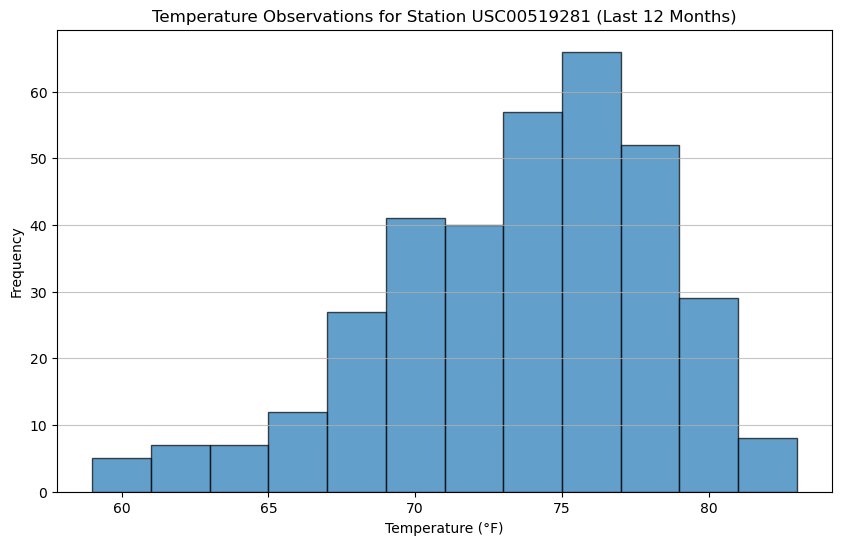

In [92]:
# Plot the results as a histogram

plt.figure(figsize=(10, 6))
plt.hist(tobs_list, bins=12, alpha=0.7, edgecolor='black')
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()
